# Node representation learning with Node2Vec


In [6]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  !pip install pysmiles
  !pip install git+https://github.com/VenkateshwaranB/stellargraph.git
  !pip install rdkit
  !pip install torch_geometric
  !pip install datasets
  !pip3 install mxnet-mkl==1.6.0 numpy==1.23.1

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-nqnm7sc9
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-nqnm7sc9
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 915.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requi

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [8]:
!pip install ogb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DF with all data

In [22]:
from ogb.graphproppred import PygGraphPropPredDataset
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

#qua sta anche clintox e altri vedere bene documntazione però il codice funziona anche con uun proprio dataset, però il clintox ha la y diversa dalla nostra quindi in molti casi conviene avere a che fare con db propri, dove settiamo noi la y per bene e usiamo lo script SMILEs-MOL-OGB
all_data = dataset[:]

In [32]:
import pickle
import torch_geometric
# Load Data object from file
with open('/content/drive/MyDrive/clintox.pt', 'rb') as f:
    all_data = pickle.load(f)

# Now loaded_data contains the Data object
print(all_data)

[Data(x=[23, 9], edge_index=[2, 46], edge_attr=[46, 3], y=[1, 1], num_nodes=23), Data(x=[33, 9], edge_index=[2, 66], edge_attr=[66, 3], y=[1, 1], num_nodes=33), Data(x=[14, 9], edge_index=[2, 28], edge_attr=[28, 3], y=[1, 1], num_nodes=14), Data(x=[21, 9], edge_index=[2, 42], edge_attr=[42, 3], y=[1, 1], num_nodes=21), Data(x=[16, 9], edge_index=[2, 32], edge_attr=[32, 3], y=[1, 1], num_nodes=16), Data(x=[15, 9], edge_index=[2, 30], edge_attr=[30, 3], y=[1, 1], num_nodes=15), Data(x=[12, 9], edge_index=[2, 24], edge_attr=[24, 3], y=[1, 1], num_nodes=12), Data(x=[14, 9], edge_index=[2, 28], edge_attr=[28, 3], y=[1, 1], num_nodes=14), Data(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], y=[1, 1], num_nodes=11), Data(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], y=[1, 1], num_nodes=11), Data(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], y=[1, 1], num_nodes=11), Data(x=[12, 9], edge_index=[2, 24], edge_attr=[24, 3], y=[1, 1], num_nodes=12), Data(x=[20, 9], edge_index=[2, 40], edg

In [3]:
import torch
import networkx as nx
import stellargraph as sg
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from stellargraph.data import BiasedRandomWalk

def create_networkx_graph(edge_index, edge_attr, x, y, num_nodes):
    # Create an empty NetworkX graph
    G = nx.Graph()

    # Add nodes with features
    for i in range(num_nodes):
        node_features = {f"feat_{j}": x[i, j].item() for j in range(x.shape[1])}
        G.add_node(i, features=node_features)

    # Add edges with attributes
    for j in range(edge_index.shape[1]):
        src, dst = edge_index[:, j].tolist()
        edge_attributes = {f"attr_{k}": edge_attr[j, k].item() for k in range(edge_attr.shape[1])}
        G.add_edge(src, dst, attributes=edge_attributes)

    return G, y.item()

#Node2Vec

Construction of the dataset

In [4]:
from sklearn.model_selection import KFold
import copy
import random
import pandas as pd

label_0_indices = []
label_1_indices = []
dfs = []

for i in range(len(all_data)):
  if all_data[i].y == 0:
    label_0_indices.append(i)
  elif all_data[i].y == 1:
    label_1_indices.append(i)

for iter in range(5):
  print('iter:', iter)

  min_size_dataset = min(len(label_0_indices), len(label_1_indices))

  random.shuffle(label_0_indices)
  random.shuffle(label_1_indices)
  label_0_indices = label_0_indices[:min_size_dataset]
  label_1_indices = label_1_indices[:min_size_dataset]
  print('size 0 data:' , len(label_0_indices))
  print('size 1 data:', len(label_1_indices))

  balanced_indices = label_0_indices + label_1_indices
  print('size total dataset:' , len(balanced_indices))

  balanced_data = [all_data[i] for i in balanced_indices]
  print(len(balanced_data))

  df = pd.DataFrame(columns = ['emb','label'])

  for dtb in balanced_data:
    graph,y = create_networkx_graph(dtb.edge_index, dtb.edge_attr, dtb.x, dtb.y, dtb.num_nodes)
        # Convert node features to DataFrame
    node_features_dict = {node: graph.nodes[node]['features'] for node in graph.nodes}
    node_df = pd.DataFrame.from_dict(node_features_dict, orient='index')

        # Convert edge attributes to DataFrame
    edge_features_dict = {(src, dst): data['attributes'] for src, dst, data in graph.edges(data=True)}
    edge_df = pd.DataFrame.from_dict(edge_features_dict, orient='index')

        # Create 'source', 'target' columns in the edge DataFrame
    edge_df['source'] = [edge[0] for edge in edge_df.index]
    edge_df['target'] = [edge[1] for edge in edge_df.index]

        # Create a StellarGraph from the NetworkX graph and DataFrames
    Gs = sg.StellarGraph(nodes=node_df, edges=edge_df)

    rw = BiasedRandomWalk(Gs)

    walks = rw.run(
        nodes=list(Gs.nodes()),  # root nodes
        length=100,  # maximum length of a random walk
        n=10,  # number of random walks per root node
        p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
        q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
        weighted=True,
        seed = 42
    )

    str_walks = [[str(n) for n in walk] for walk in walks]
    model = Word2Vec(str_walks, window=5, min_count=0, sg=1, workers=2)

        # Retrieve node embeddings and corresponding subjects
    node_ids = model.wv.index_to_key  # list of node IDs
    node_embeddings = (
        model.wv.vectors
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality

    df.loc[len(df)] = [node_embeddings, y]
  #df.to_pickle('/content/drive/MyDrive/emb_bbbp_node2vec_data_' + str(iter + 1) + '.pkl')
  #print(df)
  dfs.append(df)
  #se va tutto bene poi questo break si toglie e si fa per tuti i kfold

iter: 0
size 0 data: 1443
size 1 data: 1443
size total dataset: 2886
2886


KeyboardInterrupt: 

Creation of the Model for classification on the Embedding data given from node2vec

In [ ]:
# Define a function to create and compile your model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(222, 100)),
    layers.Dropout(0.3),  # Adding dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Adding dropout for regularization
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),  # Adding dropout for regularization
    layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model

5 k-fold on 5 datasets

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np


# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize dictionary to store best models and their performances
best_models = {}

for df_idx, df in enumerate(dfs):
    best_accuracy = 0
    best_model = None

    # Prepare data
    X_emb = pad_sequences(df['emb'], dtype='float32', padding='post')
    y = np.array(df['label'])

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X_emb)):
        X_emb_train, X_emb_val = X_emb[train_index], X_emb[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = create_model()
        print(len((y_train.reshape(-1, 1))))
        history = model.fit(X_emb_train, y_train.reshape(-1, 1), epochs=100, batch_size=32, validation_data=(X_emb_val, y_val.reshape(-1, 1)))

        # Evaluate model performance
        _, accuracy = model.evaluate(X_emb_val, y_val)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    # Save the best model for this dataset
    best_models[f'df_{df_idx}'] = best_model
    print(f"Best accuracy for dataset {df_idx}: {best_accuracy}")


Streaming output truncated to the last 5000 lines.
Epoch 28/100
73/73 [==============================] - 5s 67ms/step - loss: 0.6723 - accuracy: 0.5319 - val_loss: 0.6956 - val_accuracy: 0.5440
Epoch 29/100
73/73 [==============================] - 5s 72ms/step - loss: 0.6715 - accuracy: 0.5324 - val_loss: 0.6985 - val_accuracy: 0.5444
Epoch 30/100
73/73 [==============================] - 3s 46ms/step - loss: 0.6711 - accuracy: 0.5329 - val_loss: 0.6993 - val_accuracy: 0.5438
Epoch 31/100
73/73 [==============================] - 5s 73ms/step - loss: 0.6707 - accuracy: 0.5331 - val_loss: 0.6974 - val_accuracy: 0.5437
Epoch 32/100
73/73 [==============================] - 3s 46ms/step - loss: 0.6702 - accuracy: 0.5333 - val_loss: 0.6968 - val_accuracy: 0.5435
Epoch 33/100
73/73 [==============================] - 3s 46ms/step - loss: 0.6699 - accuracy: 0.5334 - val_loss: 0.6967 - val_accuracy: 0.5442
Epoch 34/100
73/73 [==============================] - 5s 66ms/step - loss: 0.6698 - accurac

In [ ]:
for idx, (name, model) in enumerate(best_models.items()):
    model.save(f'/content/drive/MyDrive/best_model_bbbp{name}.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


load models

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
best_models = []
for cnt in range(5):
  best_models.append(load_model('/content/drive/MyDrive/best_model_bbbpdf_' + str(cnt) + '.h5'))

Evaluating the performances of the best models using ROC
fare file log

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Open a file to write the results
with open("/content/drive/MyDrive/metrics_results_bbbp_models.txt", "w") as file:

    # Loop through best models
    for idx, model in enumerate(best_models):
        file.write(f"\nModel {idx + 1}\n")

        df = dfs[idx]
        X_emb = pad_sequences(df['emb'], dtype='float32', padding='post')
        y = np.array(df['label'])

        # Split data into training and testing sets
        X_emb_train, X_emb_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2, random_state=42, stratify=y)

        # Pad sequences if necessary
        X_emb_train = pad_sequences(X_emb_train, dtype='float32', padding='post')
        X_emb_test = pad_sequences(X_emb_test, dtype='float32', padding='post')

        # Reshape labels if necessary
        y_train_reshaped = y_train.reshape(-1, 1)
        y_test_reshaped = y_test.reshape(-1, 1)

        # predict probabilities for test set
        yhat_probs = model.predict(X_emb_test, verbose=0)
        # predict crisp classes for test set
        y_classes = np.argmax(yhat_probs, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_classes)
        precision = precision_score(y_test, y_classes, labels=[1] , average = 'weighted')
        recall = recall_score(y_test, y_classes, labels=[1], average = 'weighted')
        f1 = f1_score(y_test, y_classes, labels=[1], average = 'weighted')
        conf_matrix = confusion_matrix(y_test, y_classes)

        file.write("Accuracy: {}\n".format(accuracy))
        file.write("Precision: {}\n".format(precision))
        file.write("Recall: {}\n".format(recall))
        file.write("F1 Score: {}\n".format(f1))

        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, y_classes)
        file.write("ROC AUC: {}\n".format(roc_auc))

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_classes)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.savefig("ROC_Model{}.png".format(idx + 1))  # Save ROC curve plot
        plt.close()


Integrated Gradients - on the classification model

In [ ]:
import numpy as np
import tensorflow as tf

def integrated_gradients(input_data, model):
    """
    Calculate integrated gradients for a given input_data and model
    """
    # Define the baseline as all zeros
    baseline = np.zeros_like(input_data)

    # Create a linear interpolation path from baseline to the actual input
    steps = 50
    interpolated_points = [baseline + (i/steps) * (input_data - baseline) for i in range(steps+1)]

    # Convert to numpy array
    interpolated_points = np.array(interpolated_points)

    # Convert to TensorFlow tensor
    interpolated_points = tf.convert_to_tensor(interpolated_points, dtype=tf.float32)

    # Get model predictions for the interpolated points
    preds = model.predict(interpolated_points)

    # Create a GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        tape.watch(interpolated_points)
        predictions = model(interpolated_points)

    # Calculate gradients with respect to input
    gradients = tape.gradient(predictions, interpolated_points)

    # Define the integrated gradients
    integrated_grads = np.mean(gradients.numpy(), axis=0) * (input_data - baseline)

    # Sum along the path to approximate the integral
    integrated_grads = np.sum(integrated_grads, axis=1)

    return integrated_grads

# Example usage
index_to_explain = 4  # Choose an index to explain
embedding_to_explain = X_emb[index_to_explain]
integrated_grads_result = integrated_gradients(embedding_to_explain, model)

2/2 [==============================] - 0s 15ms/step


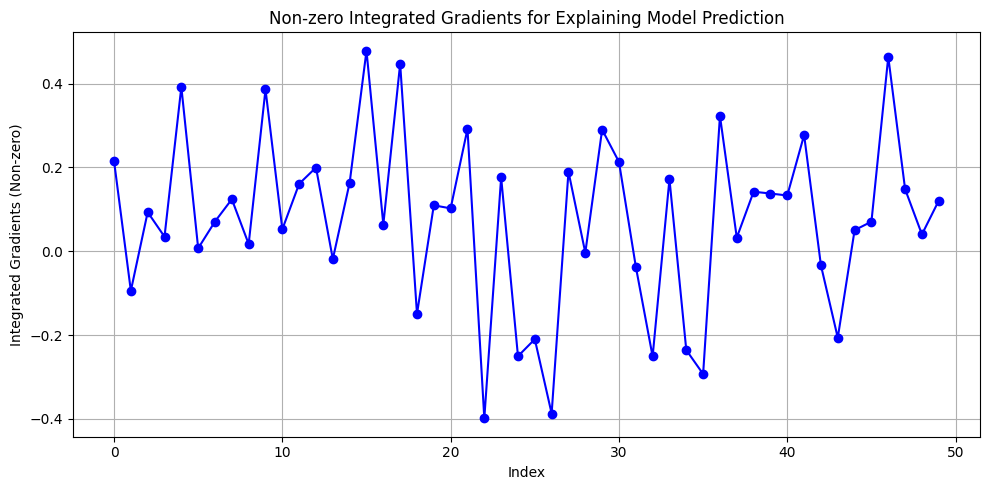

In [ ]:
import matplotlib.pyplot as plt

# Create an array of indices to use as x-axis
indices = np.arange(len(integrated_grads_result))

# Filter out non-zero values and their corresponding indices
non_zero_indices = [i for i, val in enumerate(integrated_grads_result) if val != 0]
non_zero_values = [val for val in integrated_grads_result if val != 0]

# Plot non-zero integrated gradients
plt.figure(figsize=(10, 5))
plt.plot(non_zero_indices, non_zero_values, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Integrated Gradients (Non-zero)')
plt.title('Non-zero Integrated Gradients for Explaining Model Prediction')
plt.grid(True)
plt.tight_layout()
plt.show()


#SDNE

In [20]:
import torch
import networkx as nx
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim

# Assuming 'all_data' is already defined and contains the graph data

def create_networkx_graph(edge_index, edge_attr, x, y, num_nodes):
    # Create an empty NetworkX graph
    G = nx.Graph()

    # Add nodes with features
    for i in range(num_nodes):
        node_features = {f"feat_{j}": x[i, j].item() for j in range(x.shape[1])}
        G.add_node(i, **node_features)

    # Add edges with attributes
    for j in range(edge_index.shape[1]):
        src, dst = edge_index[:, j].tolist()
        edge_attributes = {f"attr_{k}": edge_attr[j, k].item() for k in range(edge_attr.shape[1])}
        G.add_edge(src, dst, **edge_attributes)

    return G, y.item()

class SDNE(nn.Module):
    def __init__(self, input_dim, hidden_dims, alpha=1e-5, beta=5):
        super(SDNE, self).__init__()
        self.alpha = alpha
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1])
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim)
        )

    def forward(self, x, adj):
        # Encode
        y = self.encoder(x)
        # Decode
        x_hat = self.decoder(y)
        return x_hat, y

    def loss_function(self, x, x_hat, y, adj):
        # Reconstruction loss
        mse = nn.MSELoss()
        L_1st = mse(x_hat, x)

        # Laplacian regularization
        L_2nd = torch.sum(adj * torch.norm(y.unsqueeze(1) - y, dim=2))

        return L_1st + self.alpha * L_1st + self.beta * L_2nd

def train_sdne(graph, hidden_dims=[128, 64], epochs=100, lr=0.01):
    # Create adjacency matrix
    adj = nx.adjacency_matrix(graph).todense()
    adj = torch.tensor(adj, dtype=torch.float32)

    # Get node features
    node_features = np.array([list(graph.nodes[i].values()) for i in range(graph.number_of_nodes())])

    # Check if node features are empty
    if node_features.shape[1] == 0:
        raise ValueError("Node features are empty. Ensure nodes have features.")

    scaler = MinMaxScaler()
    node_features = scaler.fit_transform(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float32)

    # Initialize model
    input_dim = node_features.shape[1]
    model = SDNE(input_dim, hidden_dims)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        x_hat, y = model(node_features, adj)
        loss = model.loss_function(node_features, x_hat, y, adj)
        loss.backward()
        optimizer.step()

        #if (epoch + 1) % 10 == 0:
            #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, y

def balance_dataset(all_data):
    label_0_indices = [i for i, data in enumerate(all_data) if data.y == 0]
    label_1_indices = [i for i, data in enumerate(all_data) if data.y == 1]

    min_size_dataset = min(len(label_0_indices), len(label_1_indices))

    random.shuffle(label_0_indices)
    random.shuffle(label_1_indices)

    label_0_indices = label_0_indices[:min_size_dataset]
    label_1_indices = label_1_indices[:min_size_dataset]
    print(len(label_0_indices))
    print(len(label_1_indices))

    balanced_indices = label_0_indices + label_1_indices
    random.shuffle(balanced_indices)

    balanced_data = [all_data[i] for i in balanced_indices]

    return balanced_data

# Generate and save embeddings for the balanced datasets
if __name__ == "__main__":
    all_graph_embeddings = []

    for i in range(1):  # Loop to generate 5 different datasets
        print(f'Generating dataset {i + 1}')
        balanced_data = balance_dataset(all_data)

        for data in balanced_data:
            num_nodes = data.num_nodes
            edge_index = data.edge_index
            edge_attr = data.edge_attr
            x = data.x
            y = data.y

            # Create graph
            G, y_label = create_networkx_graph(edge_index, edge_attr, x, y, num_nodes)

            # Train SDNE
            model, embeddings = train_sdne(G, epochs=100)

            # Collect node embeddings and aggregate them to obtain a graph-level embedding
            embeddings_np = embeddings.detach().numpy()
            graph_embedding = np.mean(embeddings_np, axis=0)  # Averaging node embeddings
            all_graph_embeddings.append((graph_embedding.tolist(), y_label))

    # Convert graph-level embeddings to DataFrame
    df_graph_embeddings = pd.DataFrame(all_graph_embeddings, columns=["embedding", "label"])

    # Save the DataFrame to a CSV file (optional)
    df_graph_embeddings.to_csv("graph_embeddings.csv", index=False)

    # Print the DataFrame
    print(df_graph_embeddings)


Generating dataset 1
112
112
                                             embedding  label
0    [0.0639788806438446, 0.06521560251712799, 0.03...      1
1    [-0.13483938574790955, -0.1800384223461151, -0...      1
2    [0.08756901323795319, 0.06761772185564041, -0....      0
3    [0.01694951206445694, -0.05306106433272362, 0....      1
4    [-0.04527962580323219, 0.006519967690110207, 0...      0
..                                                 ...    ...
219  [0.06213023141026497, 0.07088954746723175, -0....      0
220  [0.07343877106904984, 0.015459422022104263, 0....      1
221  [-0.07301987707614899, -0.035584867000579834, ...      1
222  [-0.042404189705848694, -0.005982905626296997,...      0
223  [-0.11298348754644394, -0.04112539440393448, 0...      0

[224 rows x 2 columns]


In [ ]:
df_graph_embeddings

,embedding,label
0,"[0.012872357852756977, 0.036167778074741364, 0...",1
1,"[0.02220860868692398, -0.0034232004545629025, ...",1
2,"[-0.034402377903461456, 0.03993811085820198, 0...",0
3,"[0.03250516951084137, -0.041709255427122116, 0...",1
4,"[0.0890597328543663, -0.018752433359622955, 0....",1
...,...,...
2881,"[-0.07019953429698944, 0.03325891122221947, 0....",0
2882,"[0.007876122370362282, 0.04717765375971794, 0....",1
2883,"[-0.11123344302177429, 0.02893875353038311, -0...",0
2884,"[-0.000383681443054229, -0.043122611939907074,...",1


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import ast

# Load the balanced dataset
df_graph_embeddings = pd.read_csv("graph_embeddings.csv")

# Extract features and labels
def extract_features_labels(df):
    embeddings = []
    labels = df['label'].tolist()

    for emb in df['embedding']:
        if isinstance(emb, str):
            # Convert string representation of list back to list
            emb = ast.literal_eval(emb)
        embeddings.append(emb)

    X = np.array(embeddings)
    y = np.array(labels)
    return X, y

X, y = extract_features_labels(df_graph_embeddings)

# Check if data is loaded correctly
if X.shape[0] == 0 or X.shape[1] == 0:
    raise ValueError("No valid embeddings found. Please check the DataFrame for formatting issues.")

# Define the neural network model
def create_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Perform 5-fold cross-validation on the entire dataset
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []
test_accuracies = []
roc_aucs = []
precisions = []
recalls = []
f1_scores = []
histories = []

for train_index, test_index in kf.split(X):
    print(f'Fold {fold_no}')

    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

    # Perform an additional split to get a validation set from the training+validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

    # Create and train the neural network
    input_dim = X_train.shape[1]
    model = create_model(input_dim)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} Validation Accuracy: {val_accuracy:.4f}')
    val_accuracies.append(val_accuracy)
    histories.append(history.history)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} Test Accuracy: {test_accuracy:.4f}')
    test_accuracies.append(test_accuracy)

    # Predict probabilities and calculate metrics for the test set
    y_test_pred_proba = model.predict(X_test).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype("int32")

    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f'Fold {fold_no} ROC-AUC: {roc_auc:.4f}')
    print(f'Fold {fold_no} Precision: {precision:.4f}')
    print(f'Fold {fold_no} Recall: {recall:.4f}')
    print(f'Fold {fold_no} F1-Score: {f1:.4f}')

    roc_aucs.append(roc_auc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    fold_no += 1

# Calculate and print the average validation accuracy and variance
average_val_accuracy = np.mean(val_accuracies)
variance_val_accuracy = np.var(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy:.4f}')
print(f'Variance of Validation Accuracy: {variance_val_accuracy:.4f}')

# Calculate and print the average test accuracy and variance
average_test_accuracy = np.mean(test_accuracies)
variance_test_accuracy = np.var(test_accuracies)
print(f'Average Test Accuracy: {average_test_accuracy:.4f}')
print(f'Variance of Test Accuracy: {variance_test_accuracy:.4f}')

# Calculate and print the average ROC-AUC, Precision, Recall, and F1-Score
average_roc_auc = np.mean(roc_aucs)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(f'Average ROC-AUC: {average_roc_auc:.4f}')
print(f'Average Precision: {average_precision:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average F1-Score: {average_f1_score:.4f}')

# Save the average validation accuracy, variance, test accuracy, and metrics to a file
with open("model_accuracies.txt", "w") as f:
    f.write(f'Average Validation Accuracy: {average_val_accuracy:.4f}\n')
    f.write(f'Variance of Validation Accuracy: {variance_val_accuracy:.4f}\n')
    f.write(f'Average Test Accuracy: {average_test_accuracy:.4f}\n')
    f.write(f'Variance of Test Accuracy: {variance_test_accuracy:.4f}\n')
    f.write(f'Average ROC-AUC: {average_roc_auc:.4f}\n')
    f.write(f'Average Precision: {average_precision:.4f}\n')
    f.write(f'Average Recall: {average_recall:.4f}\n')
    f.write(f'Average F1-Score: {average_f1_score:.4f}\n')

# Print model summary
model.summary()

# Save training history for each fold (optional)
with open("training_histories.txt", "w") as f:
    for i, history in enumerate(histories):
        f.write(f'\nFold {i + 1} History:\n')
        f.write(str(history))


Fold 1
Epoch 1/50
5/5 [==============================] - 2s 153ms/step - loss: 0.6947 - accuracy: 0.5035 - val_loss: 0.6927 - val_accuracy: 0.5556
Epoch 2/50
5/5 [==============================] - 0s 49ms/step - loss: 0.6947 - accuracy: 0.4615 - val_loss: 0.6924 - val_accuracy: 0.5833
Epoch 3/50
5/5 [==============================] - 0s 54ms/step - loss: 0.6934 - accuracy: 0.4685 - val_loss: 0.6925 - val_accuracy: 0.5833
Epoch 4/50
5/5 [==============================] - 0s 67ms/step - loss: 0.6934 - accuracy: 0.4895 - val_loss: 0.6929 - val_accuracy: 0.5278
Epoch 5/50
5/5 [==============================] - 0s 64ms/step - loss: 0.6884 - accuracy: 0.5594 - val_loss: 0.6931 - val_accuracy: 0.5556
Epoch 6/50
5/5 [==============================] - 0s 66ms/step - loss: 0.6893 - accuracy: 0.5804 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 47ms/step - loss: 0.6844 - accuracy: 0.6084 - val_loss: 0.6937 - val_accuracy: 0.5278
Epoch 8/50
5/5 [===

2/2 [==============================] - 0s 7ms/step
Fold 4 ROC-AUC: 0.5120
Fold 4 Precision: 0.5882
Fold 4 Recall: 0.4000
Fold 4 F1-Score: 0.4762
Fold 5
Epoch 1/50
5/5 [==============================] - 3s 101ms/step - loss: 0.6930 - accuracy: 0.5069 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 34ms/step - loss: 0.6942 - accuracy: 0.4722 - val_loss: 0.6960 - val_accuracy: 0.4444
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6924 - accuracy: 0.5278 - val_loss: 0.6958 - val_accuracy: 0.4167
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6911 - accuracy: 0.5278 - val_loss: 0.6958 - val_accuracy: 0.5278
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6886 - accuracy: 0.6111 - val_loss: 0.6957 - val_accuracy: 0.5278
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6925 - accuracy: 0.5833 - val_loss: 0.6959 - val_accuracy: 0.5278
Epoch 7/50
5/

2/2 [==============================] - 0s 15ms/step
Fold 5 ROC-AUC: 0.5776
Fold 5 Precision: 0.5500
Fold 5 Recall: 0.4783
Fold 5 F1-Score: 0.5116
Average Validation Accuracy: 0.5056
Variance of Validation Accuracy: 0.0094
Average Test Accuracy: 0.5401
Variance of Test Accuracy: 0.0018
Average ROC-AUC: 0.5780
Average Precision: 0.5453
Average Recall: 0.5581
Average F1-Score: 0.5429
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 128)               8320      
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_57 (Dense)            (None, 64)                8256      
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         

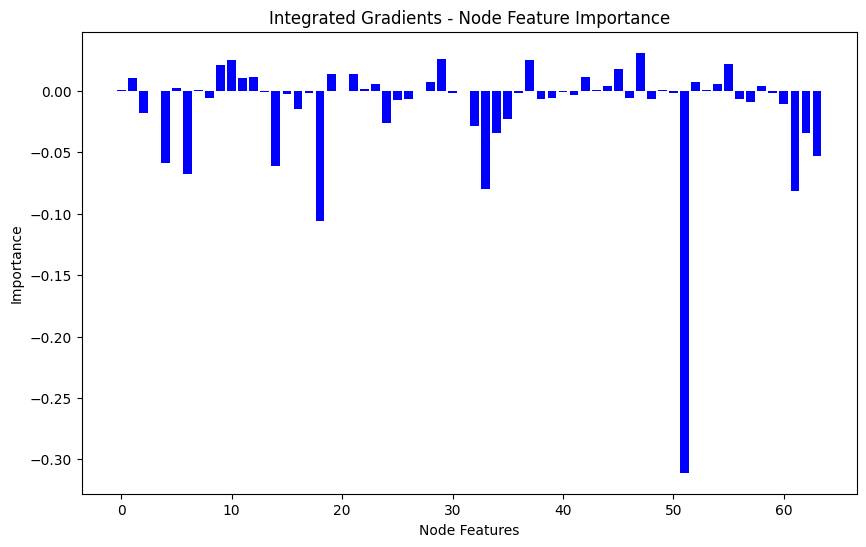

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import ast
import matplotlib.pyplot as plt

# Load the balanced dataset
#df_embeddings = pd.read_csv("sdne_embeddings.csv")

# Extract features and labels
def extract_features_labels(df):
    embeddings = []
    labels = df['label'].tolist()

    for emb in df['embedding']:
        if isinstance(emb, str):
            emb = ast.literal_eval(emb)
        embeddings.append(emb)

    X = np.array(embeddings)
    y = np.array(labels)
    return X, y

X, y = extract_features_labels(df_graph_embeddings)

# Split the dataset into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Load the trained model
model = keras.models.load_model("node_classification_model_final.h5")

# Integrated Gradients function
def integrated_gradients(inputs, model, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros(inputs.shape)

    # Scale inputs and compute gradients
    scaled_inputs = np.array([baseline + (float(i) / steps) * (inputs - baseline) for i in range(steps + 1)], dtype=np.float32)
    grads = np.zeros_like(inputs, dtype=np.float32)

    for i, input_batch in enumerate(scaled_inputs):
        input_batch_tensor = tf.convert_to_tensor(input_batch, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(input_batch_tensor)
            predictions = model(input_batch_tensor)
            loss = tf.reduce_sum(predictions, axis=0)
        grads += tape.gradient(loss, input_batch_tensor).numpy()

    integrated_grads = (inputs - baseline) * grads / steps
    return integrated_grads

# Example usage of Integrated Gradients
index_to_explain = 0  # Choose an index to explain
embedding_to_explain = X_test[index_to_explain:index_to_explain+1]

integrated_grads_result = integrated_gradients(embedding_to_explain, model)

# Visualize the Integrated Gradients
plt.figure(figsize=(10, 6))
plt.bar(range(len(integrated_grads_result[0])), integrated_grads_result[0], color='b')
plt.xlabel("Node Features")
plt.ylabel("Importance")
plt.title("Integrated Gradients - Node Feature Importance")
plt.show()

# Save Integrated Gradients to a file
np.savetxt("integrated_gradients.csv", integrated_grads_result, delimiter=",")


#HOPE

In [36]:
import torch
import networkx as nx
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

def create_networkx_graph(edge_index, edge_attr, x, y, num_nodes):
    # Create an empty NetworkX graph
    G = nx.Graph()

    # Add nodes with features
    for i in range(num_nodes):
        node_features = {f"feat_{j}": x[i, j].item() for j in range(x.shape[1])}
        G.add_node(i, **node_features)

    # Add edges with attributes
    for j in range(edge_index.shape[1]):
        src, dst = edge_index[:, j].tolist()
        edge_attributes = {f"attr_{k}": edge_attr[j, k].item() for k in range(edge_attr.shape[1])}
        G.add_edge(src, dst, **edge_attributes)

    return G, y.item()

def balance_dataset(all_data):
    label_0_indices = [i for i, data in enumerate(all_data) if data.y.item() == 0]
    label_1_indices = [i for i, data in enumerate(all_data) if data.y.item() == 1]

    min_size_dataset = min(len(label_0_indices), len(label_1_indices))

    random.shuffle(label_0_indices)
    random.shuffle(label_1_indices)

    label_0_indices = label_0_indices[:min_size_dataset]
    label_1_indices = label_1_indices[:min_size_dataset]
    print(len(label_0_indices))
    print(len(label_1_indices))

    balanced_indices = label_0_indices + label_1_indices
    random.shuffle(balanced_indices)

    balanced_data = [all_data[i] for i in balanced_indices]

    return balanced_data

def compute_hope_embedding(G, d=128, beta=0.01):
    # Create adjacency matrix
    A = nx.to_numpy_array(G)

    # Compute the Katz similarity matrix
    I = np.eye(A.shape[0])
    S = np.linalg.inv(I - beta * A) - I

    # Ensure k is valid for SVD
    k = min(d // 2, min(S.shape) - 1)

    if k <= 0:
        # If k is invalid, return trivial embeddings
        return np.zeros((S.shape[0], d))

    # Compute SVD
    U, s, Vt = svds(S, k=k)
    S_sqrt = np.diag(np.sqrt(s))
    X1 = np.dot(U, S_sqrt)
    X2 = np.dot(Vt.T, S_sqrt)
    X = np.concatenate((X1, X2), axis=1)

    # Ensure the final embedding dimension matches d
    if X.shape[1] < d:
        X = np.pad(X, ((0, 0), (0, d - X.shape[1])), 'constant')
    elif X.shape[1] > d:
        X = X[:, :d]

    return X

# Generate and save embeddings for the balanced datasets
if __name__ == "__main__":
    all_graph_embeddings = []

    for i in range(5):  # Loop to generate embeddings from 5 different balanced datasets
        print(f'Generating embeddings for dataset {i + 1}')
        balanced_data = balance_dataset(all_data)

        for data in balanced_data:
            num_nodes = data.num_nodes
            edge_index = data.edge_index
            edge_attr = data.edge_attr
            x = data.x
            y = data.y

            # Create graph
            G, y_label = create_networkx_graph(edge_index, edge_attr, x, y, num_nodes)

            # Compute HOPE embeddings
            embeddings = compute_hope_embedding(G, d=128, beta=0.01)

            # Collect node embeddings and aggregate them to obtain a graph-level embedding
            graph_embedding = np.mean(embeddings, axis=0)  # Averaging node embeddings
            all_graph_embeddings.append((graph_embedding.tolist(), y_label))

    # Convert graph-level embeddings to DataFrame
    df_graph_embeddings = pd.DataFrame(all_graph_embeddings, columns=["embedding", "label"])

    # Save the DataFrame to a CSV file (optional)
    df_graph_embeddings.to_csv("graph_embeddings.csv", index=False)

    # Print the DataFrame
    print(df_graph_embeddings)


Generating embeddings for dataset 1
112
112


KeyboardInterrupt: 

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import ast

# Load the balanced dataset
# df_graph_embeddings = pd.read_csv("graph_embeddings.csv")

# Extract features and labels
def extract_features_labels(df):
    embeddings = []
    labels = df['label'].tolist()

    for emb in df['embedding']:
        if isinstance(emb, str):
            # Convert string representation of list back to list
            emb = ast.literal_eval(emb)
        embeddings.append(emb)

    X = np.array(embeddings)
    y = np.array(labels)
    return X, y

# Assuming df_graph_embeddings is already defined and loaded
X, y = extract_features_labels(df_graph_embeddings)

# Check if data is loaded correctly
if X.shape[0] == 0 or X.shape[1] == 0:
    raise ValueError("No valid embeddings found. Please check the DataFrame for formatting issues.")

# Define the neural network model
def create_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Perform 5-fold cross-validation on the entire dataset
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []
test_accuracies = []
histories = []

roc_aucs = []
precisions = []
recalls = []
f1_scores = []

for train_index, test_index in kf.split(X):
    print(f'Fold {fold_no}')

    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

    # Perform an additional split to get a validation set from the training+validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

    # Create and train the neural network
    input_dim = X_train.shape[1]
    model = create_model(input_dim)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} Validation Accuracy: {val_accuracy:.4f}')
    val_accuracies.append(val_accuracy)
    histories.append(history.history)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} Test Accuracy: {test_accuracy:.4f}')
    test_accuracies.append(test_accuracy)

    # Make predictions on the test set
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Compute and store metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_aucs.append(roc_auc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f'Fold {fold_no} ROC AUC: {roc_auc:.4f}')
    print(f'Fold {fold_no} Precision: {precision:.4f}')
    print(f'Fold {fold_no} Recall: {recall:.4f}')
    print(f'Fold {fold_no} F1-Score: {f1:.4f}')

    fold_no += 1

# Calculate and print the average metrics
average_val_accuracy = np.mean(val_accuracies)
variance_val_accuracy = np.var(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy:.4f}')
print(f'Variance of Validation Accuracy: {variance_val_accuracy:.4f}')

average_test_accuracy = np.mean(test_accuracies)
variance_test_accuracy = np.var(test_accuracies)
print(f'Average Test Accuracy: {average_test_accuracy:.4f}')
print(f'Variance of Test Accuracy: {variance_test_accuracy:.4f}')

average_roc_auc = np.mean(roc_aucs)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1_scores)

print(f'Average ROC AUC: {average_roc_auc:.4f}')
print(f'Average Precision: {average_precision:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average F1-Score: {average_f1:.4f}')

# Save the average metrics to a file
with open("model_accuracies.txt", "w") as f:
    f.write(f'Average Validation Accuracy: {average_val_accuracy:.4f}\n')
    f.write(f'Variance of Validation Accuracy: {variance_val_accuracy:.4f}\n')
    f.write(f'Average Test Accuracy: {average_test_accuracy:.4f}\n')
    f.write(f'Variance of Test Accuracy: {variance_test_accuracy:.4f}\n')
    f.write(f'Average ROC AUC: {average_roc_auc:.4f}\n')
    f.write(f'Average Precision: {average_precision:.4f}\n')
    f.write(f'Average Recall: {average_recall:.4f}\n')
    f.write(f'Average F1-Score: {average_f1:.4f}\n')

# Print model summary
model.summary()

# Save training history for each fold (optional)
with open("training_histories.txt", "w") as f:
    for i, history in enumerate(histories):
        f.write(f'\nFold {i + 1} History:\n')
        f.write(str(history))


Fold 1
Epoch 1/50
5/5 [==============================] - 2s 107ms/step - loss: 0.6936 - accuracy: 0.4685 - val_loss: 0.6925 - val_accuracy: 0.5278
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6928 - accuracy: 0.5105 - val_loss: 0.6926 - val_accuracy: 0.5278
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6925 - accuracy: 0.5245 - val_loss: 0.6926 - val_accuracy: 0.5278
Epoch 4/50
5/5 [==============================] - 0s 28ms/step - loss: 0.6924 - accuracy: 0.5175 - val_loss: 0.6923 - val_accuracy: 0.5278
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6908 - accuracy: 0.5245 - val_loss: 0.6921 - val_accuracy: 0.5278
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6908 - accuracy: 0.5245 - val_loss: 0.6919 - val_accuracy: 0.5278
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6903 - accuracy: 0.5245 - val_loss: 0.6918 - val_accuracy: 0.5278
Epoch 8/50
5/5 [===